# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [37]:
#%tensorflow_version 1.x
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [38]:
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

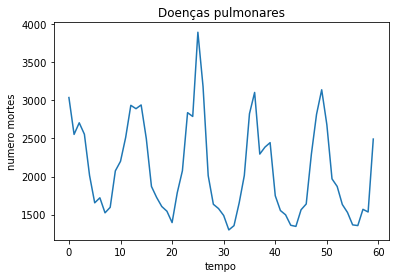

In [39]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("numero mortes")
plt.title("Doenças pulmonares")
plt.show()

### Normalização

In [40]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Criar a estrutura de dados com janela 10 e output 1

In [41]:
window = 10
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [42]:
X_train.shape

(50, 10)

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [44]:
X_train.shape

(50, 10, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [46]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 160, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 96, return_sequences = False))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 160)           103680    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 160)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 80)            77120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 96)                67968     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 97        
Total para

### Treinamento

In [47]:
regressor.fit(X_train, y_train, epochs = 250, batch_size = 32)

Epoch 1/250
50/50 [==============================] - 6s 117ms/step - loss: 0.1424
Epoch 2/250
50/50 [==============================] - 1s 19ms/step - loss: 0.1061
Epoch 3/250
50/50 [==============================] - 1s 20ms/step - loss: 0.0825
Epoch 4/250
50/50 [==============================] - 1s 19ms/step - loss: 0.0886
Epoch 5/250
50/50 [==============================] - 1s 19ms/step - loss: 0.0824
Epoch 6/250
50/50 [==============================] - 1s 18ms/step - loss: 0.0731
Epoch 7/250
50/50 [==============================] - 1s 20ms/step - loss: 0.0692
Epoch 8/250
50/50 [==============================] - 1s 18ms/step - loss: 0.0700
Epoch 9/250
50/50 [==============================] - 1s 19ms/step - loss: 0.0682
Epoch 10/250
50/50 [==============================] - 1s 19ms/step - loss: 0.0664
Epoch 11/250
50/50 [==============================] - 1s 18ms/step - loss: 0.0646
Epoch 12/250
50/50 [==============================] - 1s 16ms/step - loss: 0.0639
Epoch 13/250
50/50 [====

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [48]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [49]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [50]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

### Visualizar os resultados de treino e teste

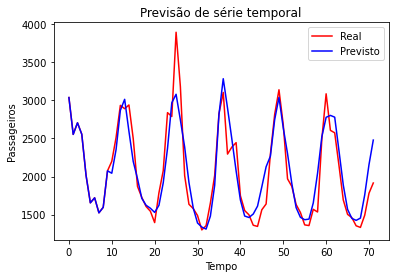

In [51]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_trainingxtest_3Layers_160x80x96Neurons.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [52]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  258.6761694766121


In [53]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  66913.36065509294


In [54]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  11.144473179840091 %
